# Physics Approximating Neural Networks

$\exists F, \forall i \ni F\big(\mathbb{F}(x_i)\big) = y_i \quad,\quad  x \in \mathcal{D}^x \ , y \in \mathcal{D}^y$

$\mathbb{H}\circ\Bigg[\sum^{(l\rightarrow L,\mathbf{p})}_0\Bigg]\circ\mathbb{F}^*\circ\Bigg[\sum^{(0\rightarrow l,\mathbf{p})}_0\Bigg](x) = \hat{y} \approx y = F \circ \mathbb{F}(\mathbf{x})$

## A toy example: 
Predicting the area of a rectangle given length L1 and L2.

We can compare how a dense-layered model does compared to a dense-layered model + PANN

In [1]:
# imports
import tensorflow as tf
import numpy as np

from helper_functions import *
# Create datasets
train_x, train_y = produce_data_for_rectangles(10000, high_val=10.0)

test_x, test_y = produce_data_for_rectangles(100, high_val=20.0)

Helper functions loaded successfully!


In [2]:
# Dense-layered Model
ModelInput = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(2, activation='tanh')(ModelInput)
x = tf.keras.layers.Dense(2, activation='tanh')(x)
ModelOutput = tf.keras.layers.Dense(1, activation="linear")(x)
DenseLayerModel = tf.keras.Model(ModelInput, ModelOutput)

# PANN Model
X_1Input = tf.keras.Input(shape=(1,))
X_1 = tf.keras.layers.Dense(2, activation='tanh')(X_1Input)
X_2Input = tf.keras.Input(shape=(1,))
X_2 = tf.keras.layers.Dense(2, activation='tanh')(X_2Input)
F_star = tf.matmul(X_1, X_2, transpose_b=True)
x = tf.keras.layers.Dense(2, activation='linear')(X_1Input)
ModelOutput = tf.keras.layers.Dense(1)(x)
PANNModel = tf.keras.Model([X_1Input, X_2Input], ModelOutput)

# Compile and fit models
DenseLayerModel.compile(optimizer='adam', loss='mse')
history_Dense_1 = DenseLayerModel.fit(train_x, train_y, epochs=10, batch_size=32, verbose=1)

PANNModel.compile(optimizer='adam', loss='mse')
history_PANN_1 = PANNModel.fit([train_x[:, 0], train_x[:, 1]], train_y, epochs=10, batch_size=32, verbose=1)

# Evaluate models
DenseLayerModel.evaluate(test_x, test_y)
PANNModel.evaluate([test_x[:, 0], test_x[:, 1]], test_y)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/10


2023-05-05 14:33:09.931141: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 2s 5ms/step - loss: 1063.6270
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 1000.0643
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 949.7159
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 908.1512
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 870.5261
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 835.3575
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 802.1165
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 770.5450
Epoch 9/10
313/313 [==============================] - 1s 4ms/step - loss: 740.4433
Epoch 10/10
313/313 [==============================] - 1s 4ms/step - loss: 711.7604
Epoch 1/10
313/313 [==============================] - 1s 4ms/step - loss: 1400.6042
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 1112.6106
Epoch 3/10

7604.81396484375

## Comments on Distribution Shift
As we can see from the train vs. test, the PANN model is not as affected by distributional shift.

Wherein, the models are tasked to be trained on (optimize for) a dataset that contains areas of rectangles that are of size 0 to 10, but tested on areas of rectangles sized 0 to 20.

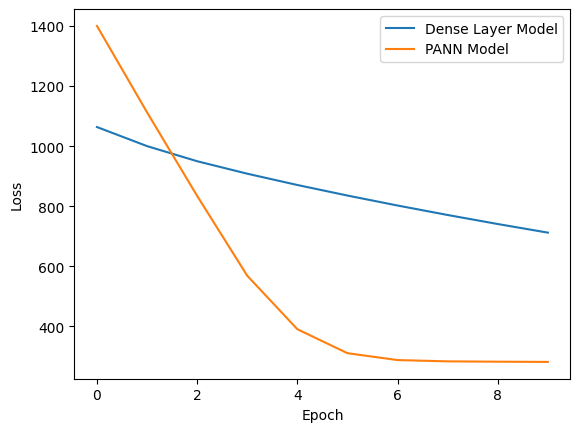

In [3]:
Dense_Loss = history_Dense_1.history['loss']
PANN_Loss = history_PANN_1.history['loss']

import matplotlib.pyplot as plt
plt.plot(Dense_Loss, label='Dense Layer Model')
plt.plot(PANN_Loss, label='PANN Model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Example: Building a Model of a Nonlinear Capacitor


$ V_t^2 = \frac{2x_t^2.(m\ddot{x}+k_1\dot{x}+k_2[x_t - x_0])}{\epsilon_{C}.A} $ 

Menno Van der Veen and Hans Van Maanen. 2008. Non-linear Distortions in
Capacitors. Journal of the Audio Engineering Society 124 (May 2008)

#### From this model, we will build a PANN model:

$\mathbb{H}\circ\Bigg[\sum^{(l\rightarrow L,\mathbf{p})}_0\Bigg]\circ\mathbb{F}^*\circ\Bigg[\sum^{(0\rightarrow l,\mathbf{p})}_0\Bigg](x)  \approx F(\mathcal{F}(.)\in F,x,H,S)$

$\mathbb{F}^* = \frac{2(\gamma(x_1))^2(\gamma(x_2)\gamma(x_3)+\gamma(x_4)\gamma(x_5)+\gamma(x_6)(\gamma(x_7)))}{\gamma(x_8)\gamma(x_9)}$

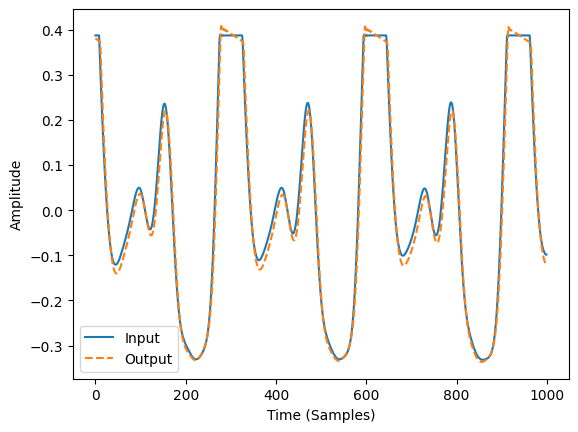

In [4]:
# Import Data
import pandas as pd

data = pd.read_csv('main-data.csv', header=0)
ModelInputData = data.iloc[:, 0:2].values
ModelOutputData = data.iloc[:, 2].values

plt.plot(ModelInputData[0:1000,0], label="Input")
plt.plot(ModelOutputData[0:1000], "--", label="Output")
plt.legend()
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.show()

In [5]:
class SampleLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):        
        # log_y_pred = tf.math.log(y_pred)
        # elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        # return tf.reduce_mean(tf.reduce_sum(elements,axis=1))
        abs_target_y = tf.math.abs(y_true)
        abs_pred_y = tf.math.abs(y_pred)
        sampleloss = abs(tf.math.subtract(abs_target_y, abs_pred_y))
        return sampleloss

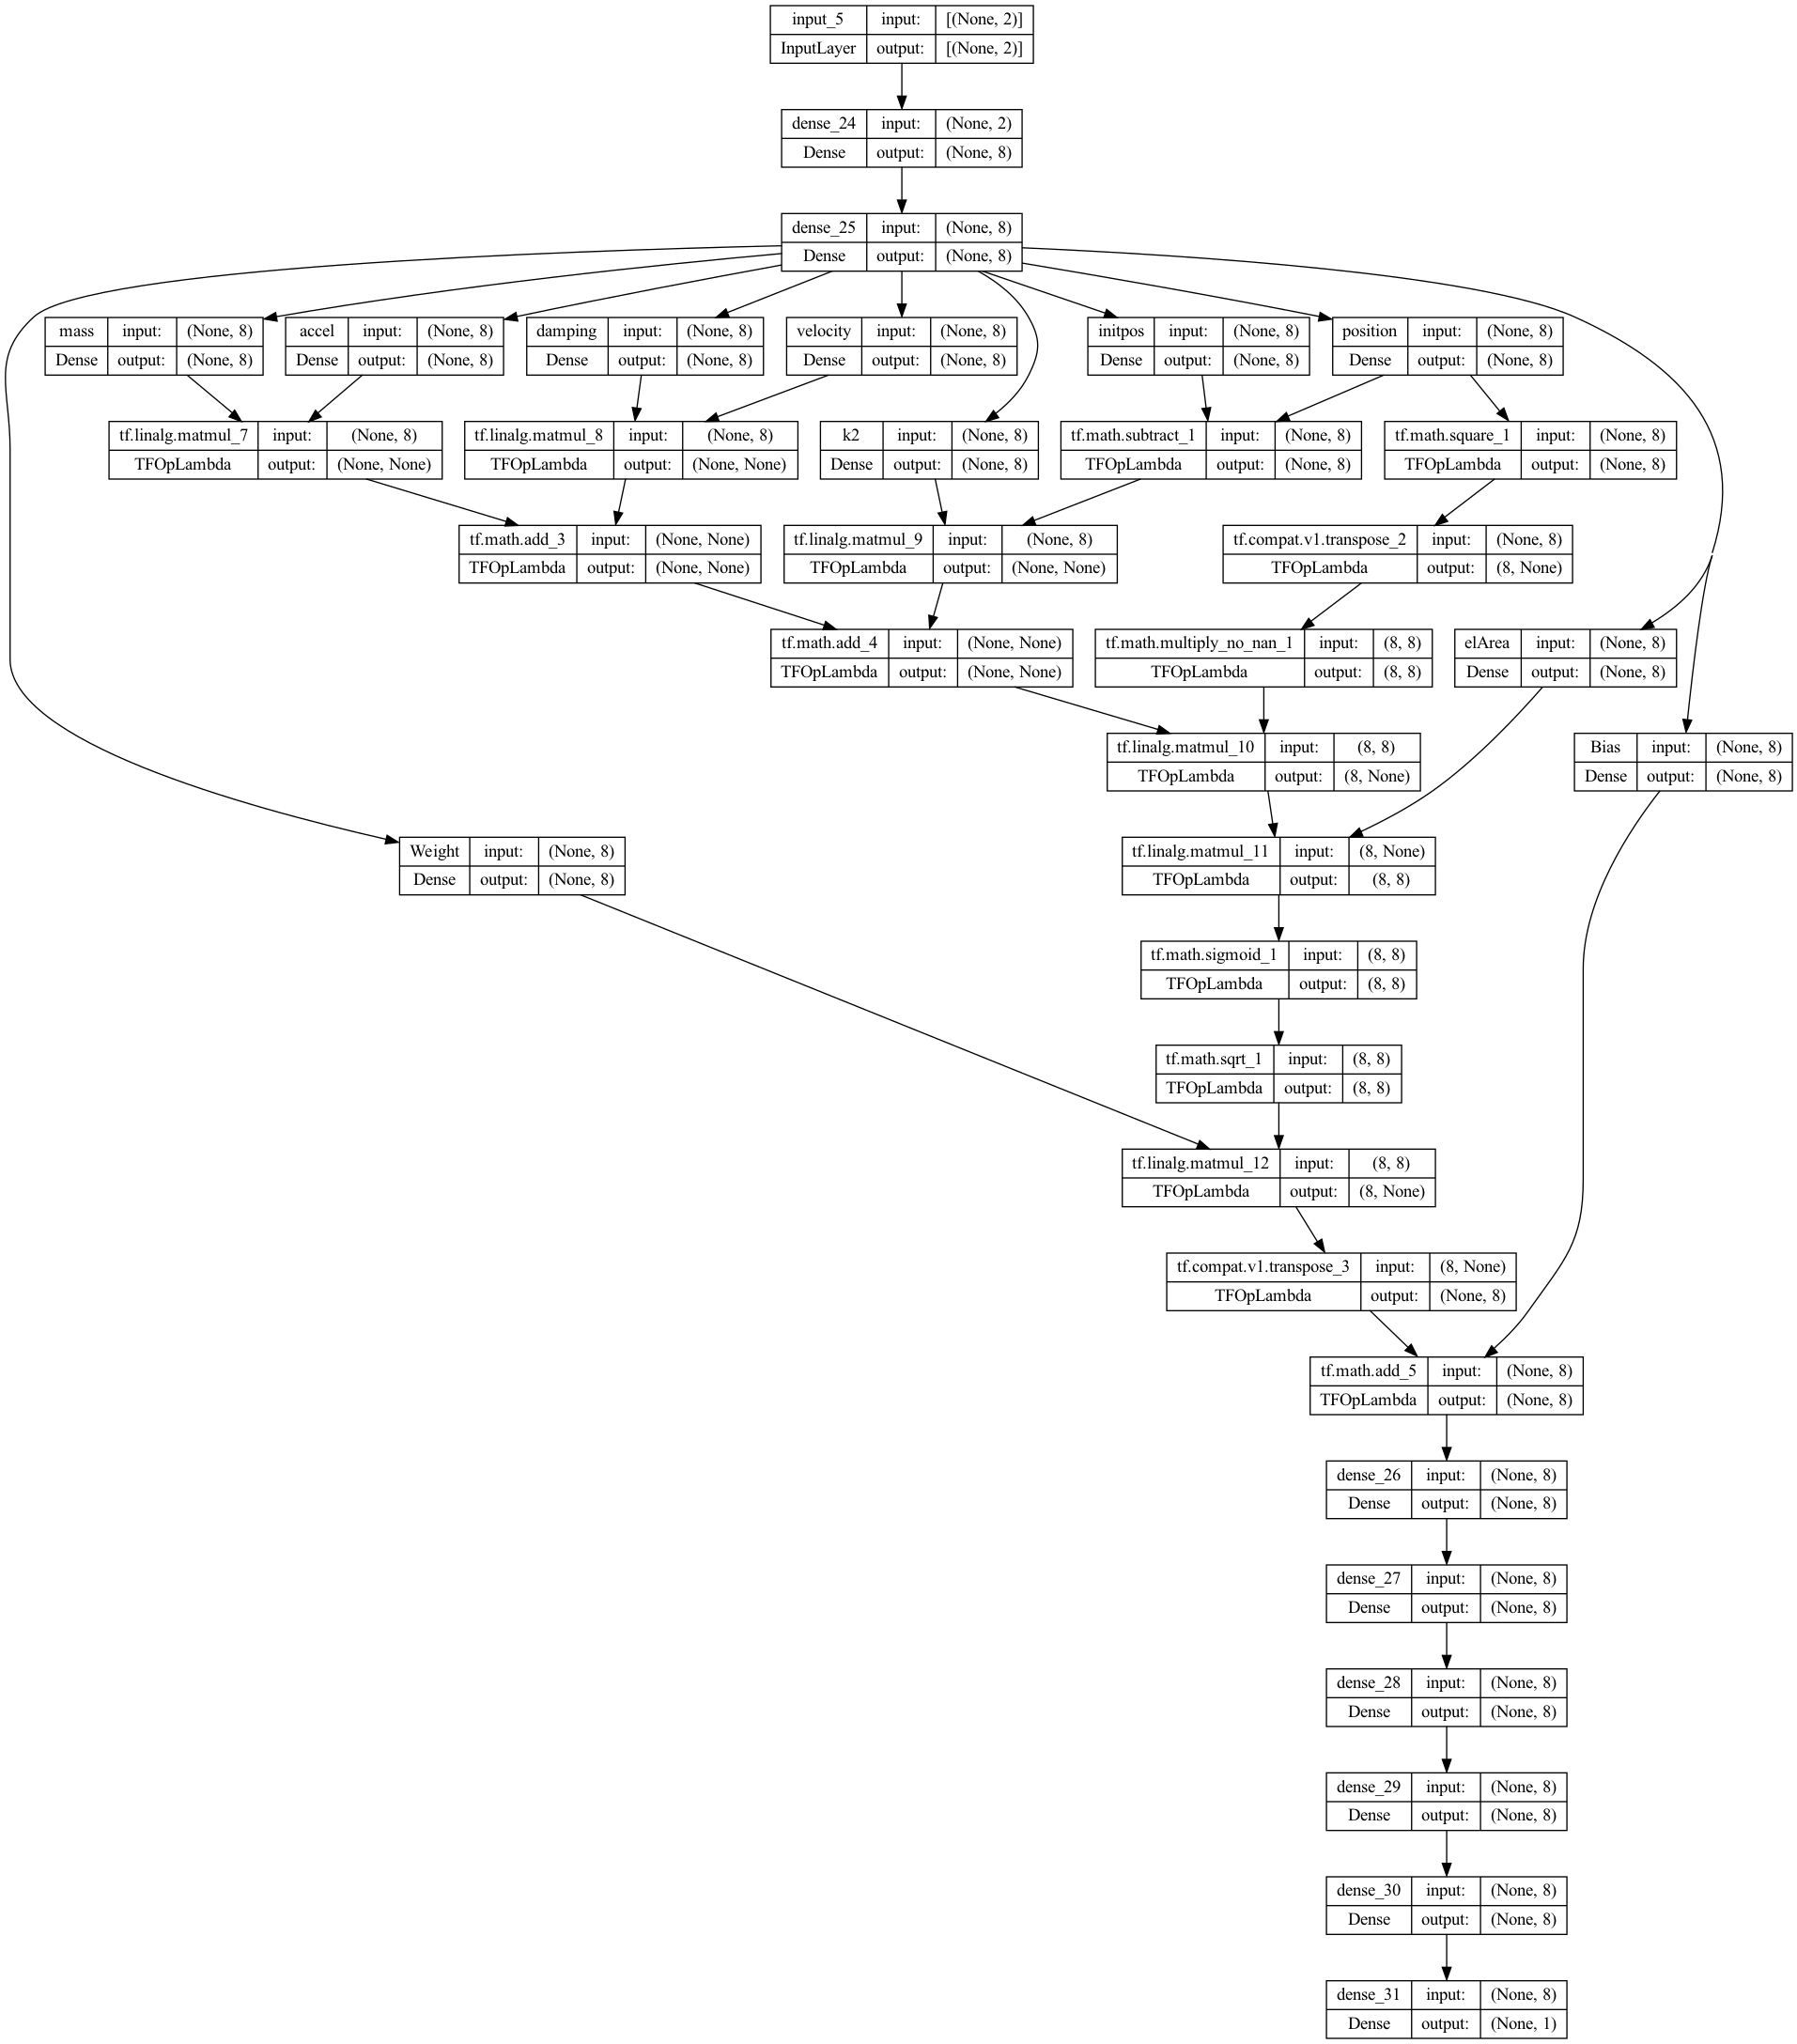

In [12]:
# Capacitor Model

ModelInput = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(8, activation='linear')(ModelInput)
x = tf.keras.layers.Dense(8, activation='linear')(x)

PANNweight = tf.keras.layers.Dense(8, name="Weight")(x)
PANNbias = tf.keras.layers.Dense(8, name="Bias")(x)

PANNelArea = tf.keras.layers.Dense(8, name="elArea")(x)
PANNmass = tf.keras.layers.Dense(8, name="mass")(x)
PANNdamping = tf.keras.layers.Dense(8, name="damping")(x)
PANNk2 = tf.keras.layers.Dense(8, name="k2")(x)
PANNoutsidebracketconstant = tf.constant(2, dtype=tf.float32 ,shape=[8, 8], name="outsidebracketconstant")
PANNpos = tf.keras.layers.Dense(8, name="position")(x)
PANNinitpos = tf.keras.layers.Dense(8, name="initpos")(x)
PANNvelocity = tf.keras.layers.Dense(8, name="velocity")(x)
PANNaccel = tf.keras.layers.Dense(8, name="accel")(x)

squareMat = tf.math.square(PANNpos)
PANNoutsidebracket = tf.math.multiply_no_nan(PANNoutsidebracketconstant, tf.transpose(squareMat))

firstTerm = tf.matmul(PANNmass, PANNaccel, transpose_b=True)

secondTerm = tf.matmul(PANNdamping, PANNvelocity, transpose_b=True)

thirdTerm_pre = tf.math.subtract(PANNpos, PANNinitpos)
thirdTerm = tf.matmul(PANNk2, thirdTerm_pre, transpose_b=True)

ans = tf.math.add(firstTerm, secondTerm)
ans = tf.math.add(ans, thirdTerm)
ans = tf.matmul(PANNoutsidebracket, ans)
ans = tf.matmul(ans, PANNelArea)

V = tf.math.sqrt(tf.nn.sigmoid(ans))

y = tf.math.add(tf.transpose(tf.matmul(V, PANNweight, transpose_b=True)), PANNbias)

y1 = tf.keras.layers.Dense(8)(y)
y2 = tf.keras.layers.Dense(8)(y1)
y3 = tf.keras.layers.Dense(8)(y2)
y4 = tf.keras.layers.Dense(8)(y3)
y5 = tf.keras.layers.Dense(8)(y4)

ModelOutput = tf.keras.layers.Dense(1)(y5)

PANNModel = tf.keras.Model(ModelInput, ModelOutput)

# Compile and fit models
optimizerA = tf.keras.optimizers.Adagrad(learning_rate=8e-3, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')
PANNModel.compile(optimizer=optimizerA, loss=SampleLoss())

# plot model
tf.keras.utils.plot_model(PANNModel, to_file='PANNModel.png', show_shapes=True, show_layer_names=True)






In [13]:

history_PANN_2 = PANNModel.fit(ModelInputData, ModelOutputData, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0193
Epoch 2/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.0171
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0164
Epoch 4/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0164
Epoch 5/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0162
Epoch 6/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0161
Epoch 7/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0160
Epoch 8/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0161
Epoch 9/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0158
Epoch 10/10
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0159


## Test the model on an entirely separate portion of data (not close in time in recording)

(1000, 2)
(1000,)
125/125 [==============================] - 1s 5ms/step


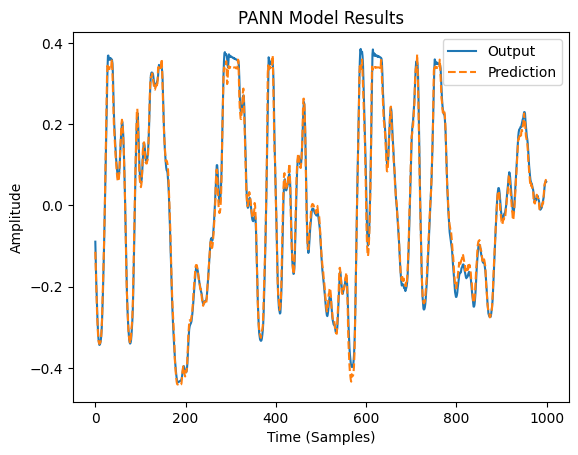

In [15]:
# Predict on the test data

test_data = pd.read_csv('test-data.csv', header=0)
TestInputData = test_data.iloc[:, 0:2].values
TestOutputData = test_data.iloc[:, 2].values

print(TestInputData.shape)
print(TestOutputData.shape)

predictions = PANNModel.predict(TestInputData, batch_size=8, verbose=1)

plt.plot(TestOutputData, label="Output")
plt.plot(predictions, "--", label="Prediction")
plt.legend()
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.title('PANN Model Results')
plt.show()


## Train a regular dense model (8x8)
so that we can compare

Epoch 1/10
10/10 [==============================] - 1s 9ms/step - loss: 0.1358
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0356
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0298
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0275
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0265
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0259
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0253
Epoch 9/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0247
Epoch 10/10
125/125 [==============================] - 0s 2ms/step


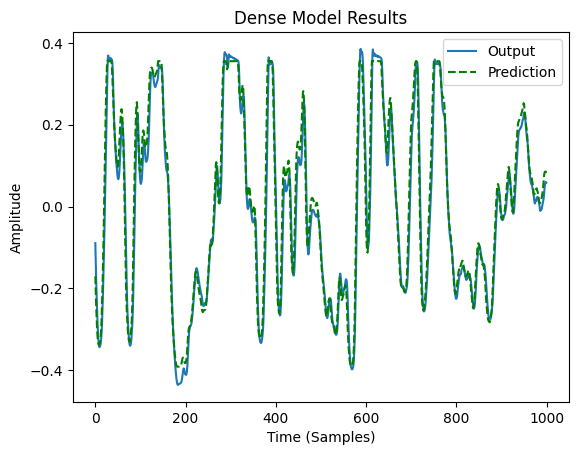

In [20]:
# Dense model
Dense_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(1)
])

Dense_2.compile(optimizer='adam', loss=SampleLoss())

history_Dense_2 = Dense_2.fit(ModelInputData, ModelOutputData, epochs=10, batch_size=1000, verbose=1)

# Predict on the test data

dense_predictions = Dense_2.predict(TestInputData, batch_size=8, verbose=1)

plt.plot(TestOutputData, label="Output")
plt.plot(dense_predictions, "g--", label="Prediction")
plt.legend()
plt.xlabel('Time (Samples)')
plt.ylabel('Amplitude')
plt.title('Dense Model Results')
plt.show()



## Compare difference graphically

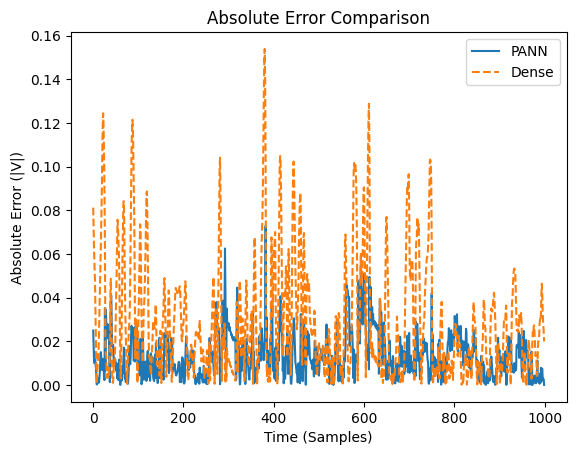

In [21]:
TestOutputData_ = np.reshape(TestOutputData, (1000, 1))
PANNabsV = np.abs(predictions-TestOutputData_)
DenseabsV = np.abs(dense_predictions-TestOutputData_)



plt.plot(PANNabsV, label="PANN")
plt.plot(DenseabsV, "--", label="Dense")
plt.legend()
plt.xlabel('Time (Samples)')
plt.ylabel('Absolute Error (|V|)')
plt.title('Absolute Error Comparison')
plt.show()
